In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression


import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.inference.tf import DragonNet
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel, compute_propensity_score
from causalml.dataset.regression import *
from causalml.metrics import *

from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
from sklift.viz import plot_uplift_by_percentile
from sklift.metrics import qini_auc_score
from imblearn.combine import SMOTEENN

import os, sys

%matplotlib inline

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
sns.set_palette('Paired')
plt.rcParams['figure.figsize'] = (12,8)


In [4]:
df_pros = pd.read_csv(f'dataframe2.csv',sep=(";")) 



cols =  ["treatment", "y_factual"] + [f'x{i}' for i in range(1,28)]


df_pros.columns = cols
df_pros.shape


(14100, 29)

In [5]:
pd.Series(df_pros['treatment']).value_counts(normalize=True)
df_copy= df_pros.copy()
df_matriz = df_copy.loc[:,'x1':]
df_matriz= (df_matriz-df_matriz.min())/(df_matriz.max()-df_matriz.min())
#df_matriz.describe()
#df_matriz.head()
df_pros.loc[:,'x1':] = df_matriz
df_pros.head()

,treatment,y_factual,x1,x2,x3,x4,x5,x6,x7,x8,...,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27
0,0,0,0.0,0.0,0.00,0.000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0.0,0.0,0.00,0.000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,1.0,1.0,0.75,0.625,0.0,1.0,0.0,0.636364,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0.0,0.0,0.00,0.000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0.0,0.0,0.00,0.000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df_int = df_pros.copy()
Y = df_int['y_factual']
treatment = df_int['treatment']
X = df_int.drop(['y_factual','treatment'],axis =1)

x_train, x_test, treatment_train, treatment_test, y_train, y_test = train_test_split(X.values,treatment,Y, test_size= 0.3, random_state = 0 ,stratify = Y)

dragon = DragonNet(neurons_per_layer=200, targeted_reg=True)
dragon_ite = dragon.fit_predict(x_train, treatment_train.to_numpy()*1.0, y_train.to_numpy()*1.0)
dragon_ate = dragon_ite.mean()
dragon_predict= dragon.predict(x_test, treatment = 'treatment_test', y = 'y_test')

Epoch 1/30
124/124 [==============================] - 2s 6ms/step - loss: 22.5406 - regression_loss: 0.6762 - binary_classification_loss: 17.2108 - treatment_accuracy: 0.8819 - track_epsilon: 0.0037 - val_loss: 18.3776 - val_regression_loss: 0.6008 - val_binary_classification_loss: 13.8788 - val_treatment_accuracy: 0.9127 - val_track_epsilon: 8.7555e-04
Epoch 2/30
124/124 [==============================] - 0s 4ms/step - loss: 17.2427 - regression_loss: 0.5355 - binary_classification_loss: 13.2712 - treatment_accuracy: 0.8963 - track_epsilon: 8.3976e-04 - val_loss: 16.1025 - val_regression_loss: 0.3542 - val_binary_classification_loss: 12.9541 - val_treatment_accuracy: 0.8964 - val_track_epsilon: 0.0011
Epoch 3/30
124/124 [==============================] - 0s 4ms/step - loss: 16.1621 - regression_loss: 0.5240 - binary_classification_loss: 12.9442 - treatment_accuracy: 0.8974 - track_epsilon: 0.0016 - val_loss: 15.3889 - val_regression_loss: 0.3783 - val_binary_classification_loss: 12.76

124/124 [==============================] - 0s 3ms/step - loss: 10.7614 - regression_loss: 0.4494 - binary_classification_loss: 9.2689 - treatment_accuracy: 0.9225 - track_epsilon: 8.0878e-04 - val_loss: 10.8093 - val_regression_loss: 0.3004 - val_binary_classification_loss: 9.6406 - val_treatment_accuracy: 0.9231 - val_track_epsilon: 4.2724e-04
Epoch 14/300
124/124 [==============================] - 0s 4ms/step - loss: 10.7677 - regression_loss: 0.4488 - binary_classification_loss: 9.2650 - treatment_accuracy: 0.9228 - track_epsilon: 3.7649e-04 - val_loss: 10.7223 - val_regression_loss: 0.3000 - val_binary_classification_loss: 9.5518 - val_treatment_accuracy: 0.9265 - val_track_epsilon: 0.0015
Epoch 15/300
124/124 [==============================] - 0s 4ms/step - loss: 10.7127 - regression_loss: 0.4493 - binary_classification_loss: 9.2539 - treatment_accuracy: 0.9225 - track_epsilon: 0.0011 - val_loss: 10.7121 - val_regression_loss: 0.2996 - val_binary_classification_loss: 9.5465 - val_

Epoch 36/300
124/124 [==============================] - 0s 3ms/step - loss: 10.6857 - regression_loss: 0.4481 - binary_classification_loss: 9.1996 - treatment_accuracy: 0.9230 - track_epsilon: 4.7719e-04 - val_loss: 10.6917 - val_regression_loss: 0.3000 - val_binary_classification_loss: 9.5281 - val_treatment_accuracy: 0.9281 - val_track_epsilon: 1.5649e-04
Epoch 37/300
124/124 [==============================] - 0s 3ms/step - loss: 10.6907 - regression_loss: 0.4478 - binary_classification_loss: 9.2104 - treatment_accuracy: 0.9238 - track_epsilon: 2.2227e-04 - val_loss: 10.6857 - val_regression_loss: 0.2999 - val_binary_classification_loss: 9.5221 - val_treatment_accuracy: 0.9260 - val_track_epsilon: 3.5760e-04
Epoch 38/300
124/124 [==============================] - 0s 4ms/step - loss: 10.6871 - regression_loss: 0.4480 - binary_classification_loss: 9.2026 - treatment_accuracy: 0.9242 - track_epsilon: 8.4440e-04 - val_loss: 10.6944 - val_regression_loss: 0.3000 - val_binary_classificatio

124/124 [==============================] - 0s 4ms/step - loss: 10.6592 - regression_loss: 0.4475 - binary_classification_loss: 9.1785 - treatment_accuracy: 0.9258 - track_epsilon: 2.3161e-04 - val_loss: 10.6857 - val_regression_loss: 0.3001 - val_binary_classification_loss: 9.5230 - val_treatment_accuracy: 0.9270 - val_track_epsilon: 1.1978e-04
Epoch 59/300
124/124 [==============================] - 0s 4ms/step - loss: 10.6460 - regression_loss: 0.4475 - binary_classification_loss: 9.1768 - treatment_accuracy: 0.9243 - track_epsilon: 5.9813e-05 - val_loss: 10.6843 - val_regression_loss: 0.3001 - val_binary_classification_loss: 9.5215 - val_treatment_accuracy: 0.9276 - val_track_epsilon: 1.6650e-04
Epoch 60/300
124/124 [==============================] - 0s 3ms/step - loss: 10.6677 - regression_loss: 0.4476 - binary_classification_loss: 9.1786 - treatment_accuracy: 0.9244 - track_epsilon: 1.3080e-04 - val_loss: 10.6851 - val_regression_loss: 0.3000 - val_binary_classification_loss: 9.522

124/124 [==============================] - 0s 4ms/step - loss: 10.6438 - regression_loss: 0.4475 - binary_classification_loss: 9.1737 - treatment_accuracy: 0.9243 - track_epsilon: 1.8509e-04 - val_loss: 10.6852 - val_regression_loss: 0.3001 - val_binary_classification_loss: 9.5225 - val_treatment_accuracy: 0.9270 - val_track_epsilon: 1.8449e-04

Epoch 00080: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.
Epoch 81/300
124/124 [==============================] - 0s 4ms/step - loss: 10.6545 - regression_loss: 0.4475 - binary_classification_loss: 9.1736 - treatment_accuracy: 0.9248 - track_epsilon: 1.8026e-04 - val_loss: 10.6852 - val_regression_loss: 0.3001 - val_binary_classification_loss: 9.5224 - val_treatment_accuracy: 0.9270 - val_track_epsilon: 1.8054e-04
Epoch 82/300
124/124 [==============================] - 0s 4ms/step - loss: 10.6522 - regression_loss: 0.4475 - binary_classification_loss: 9.1735 - treatment_accuracy: 0.9248 - track_epsilon: 1.8668e-04 - val_lo

array([<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.0558'}>,
       <AxesSubplot:title={'center':'Response rate by percentile'}, xlabel='Percentile'>],
      dtype=object)

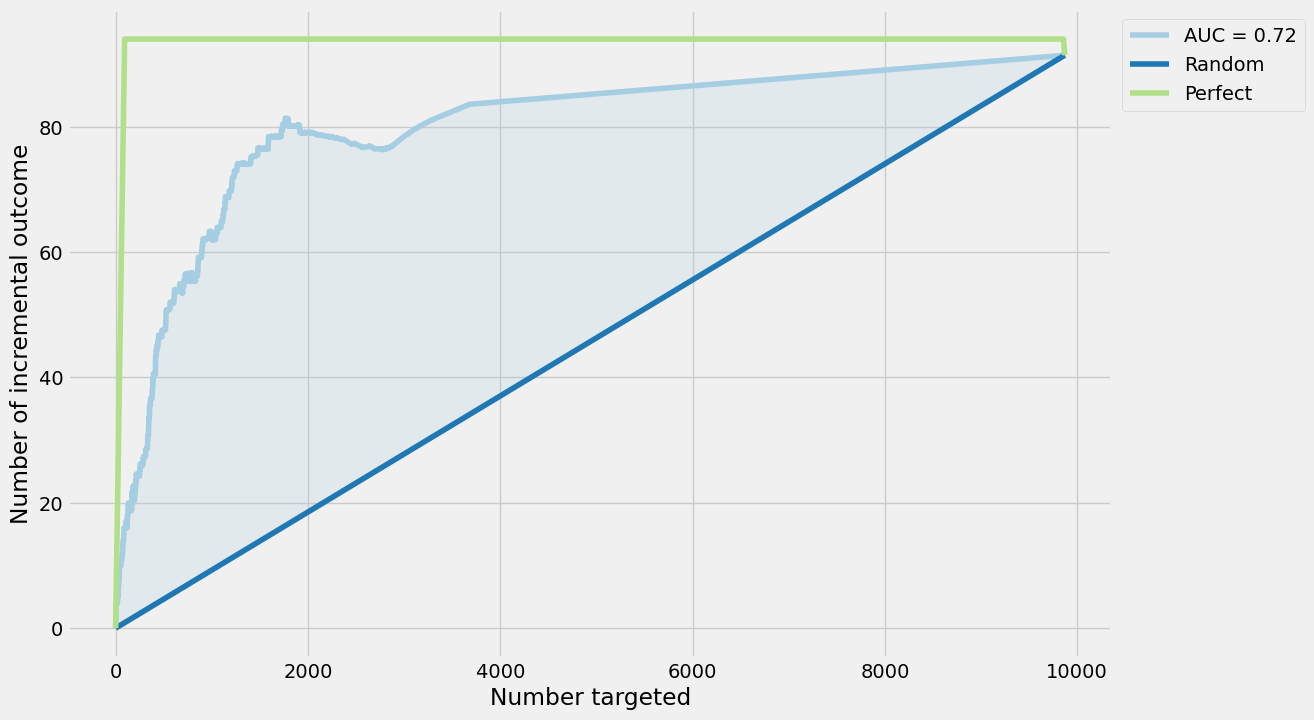

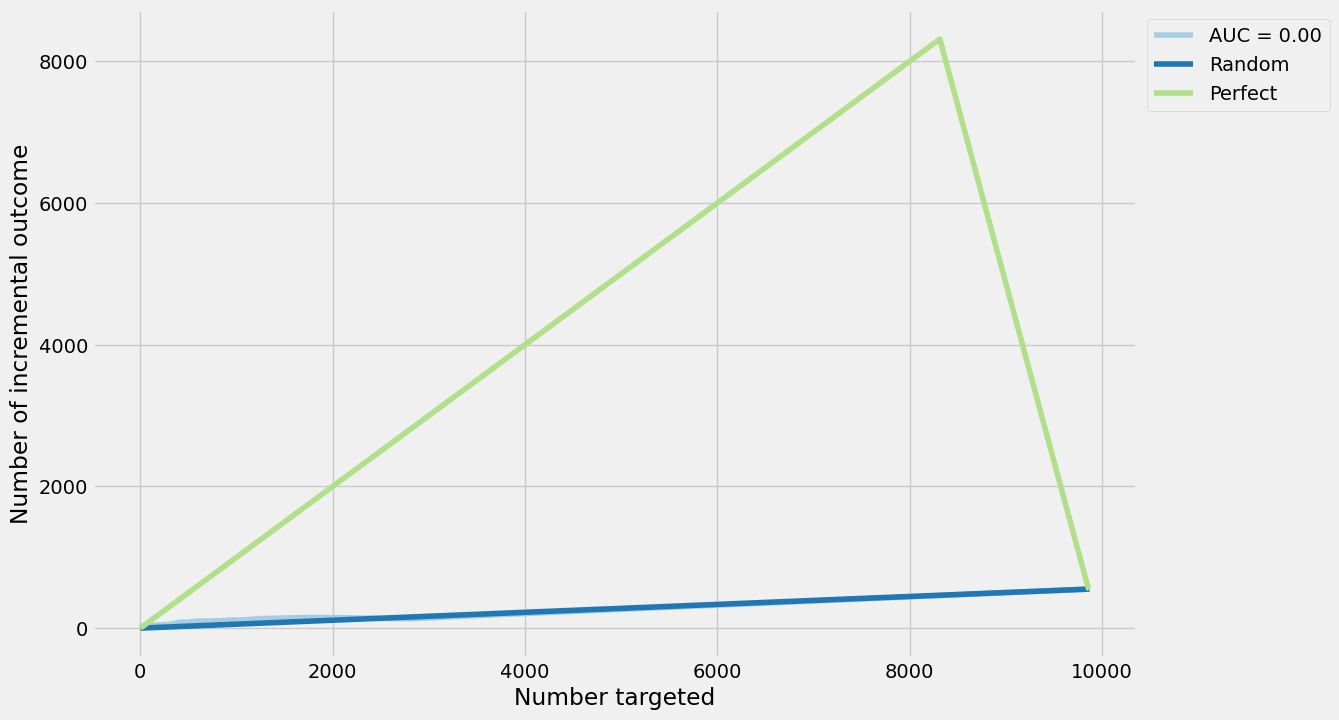

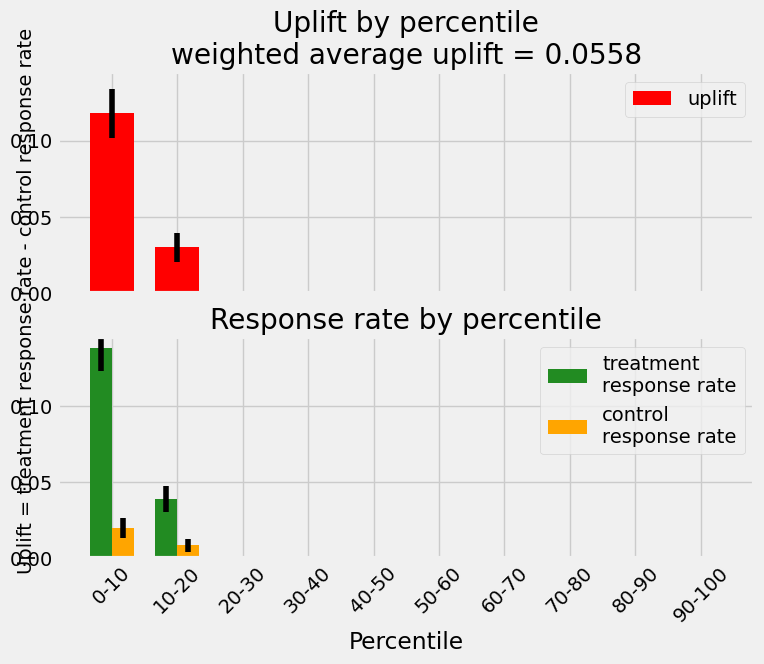

In [12]:
data = {'y_to_pred':y_train, 'uplift':dragon_ite[:,0] , 'treatment':treatment_train}
qini = qini_auc_score(y_true=data['y_to_pred'], uplift=data['uplift'], treatment=data['treatment'])

#data.sort_values( by=['uplift'] )
plot_qini_curve(y_true=data['y_to_pred'], uplift=data['uplift'], treatment=data['treatment'])
plot_uplift_curve(y_true=data['y_to_pred'], uplift=data['uplift'], treatment=data['treatment'])
plot_uplift_by_percentile(y_true=data['y_to_pred'], uplift=data['uplift'], treatment=data['treatment'],kind='bar') 

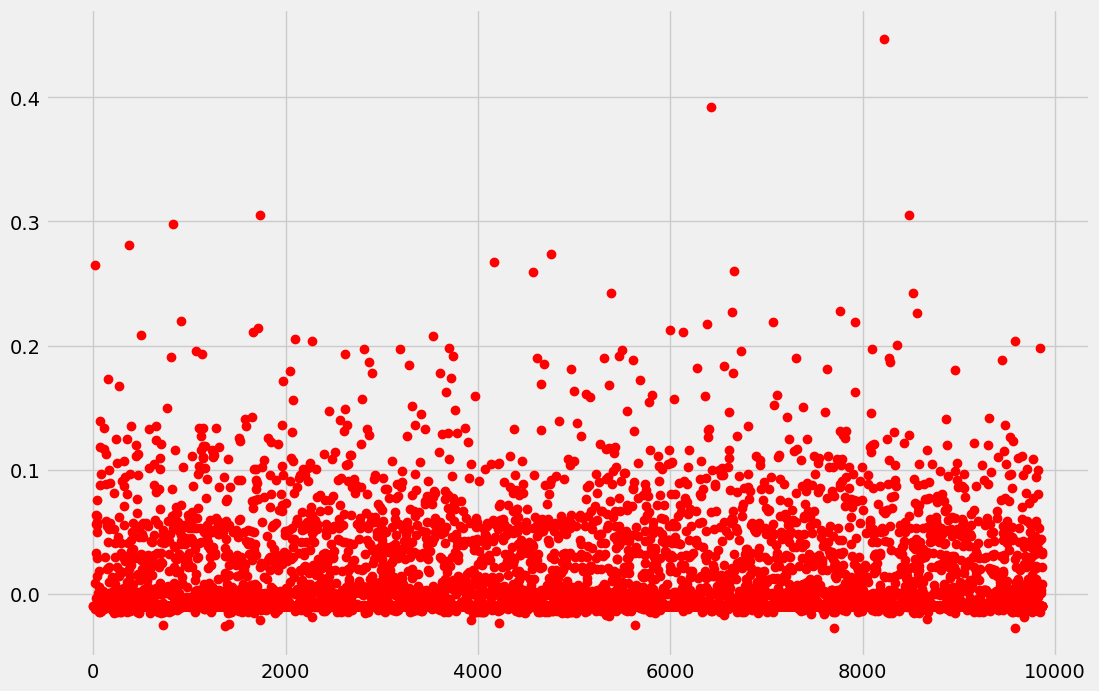

In [8]:
plt.plot(dragon_ite, 'o', color = 'red')

In [9]:
dragon_ate

0.0047286414

array([<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.0507'}>,
       <AxesSubplot:title={'center':'Response rate by percentile'}, xlabel='Percentile'>],
      dtype=object)

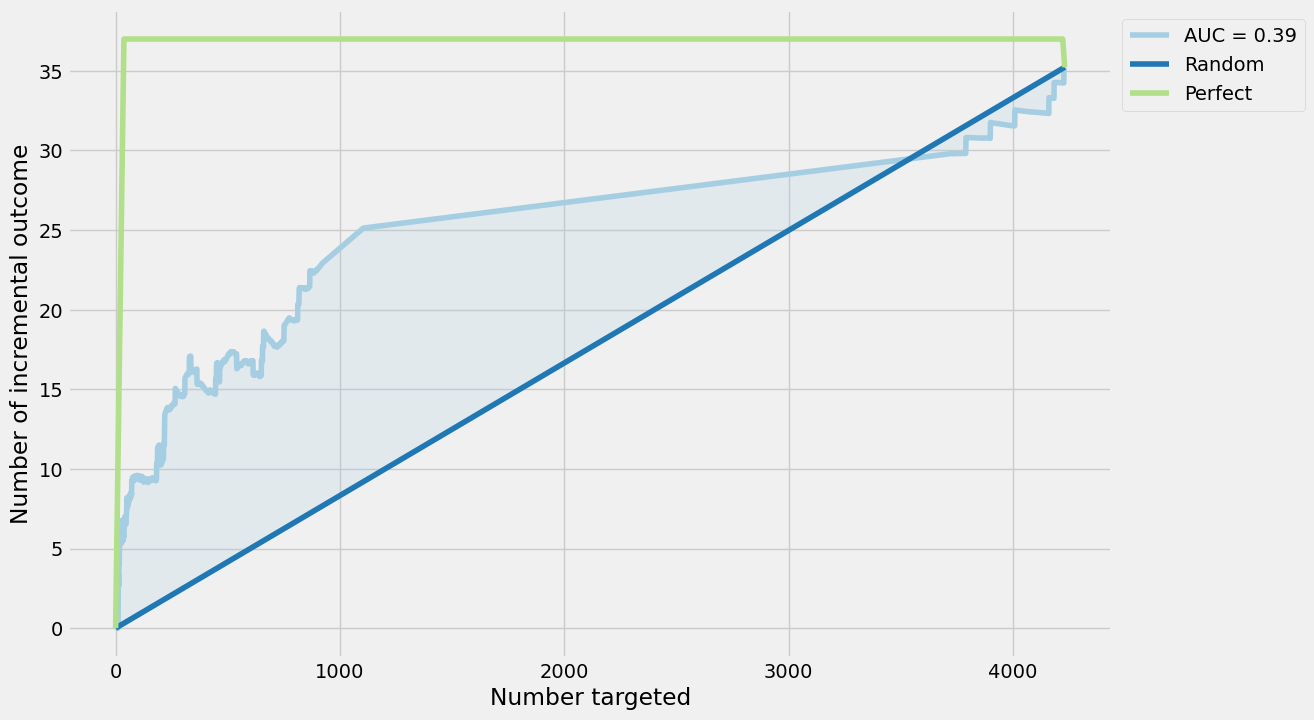

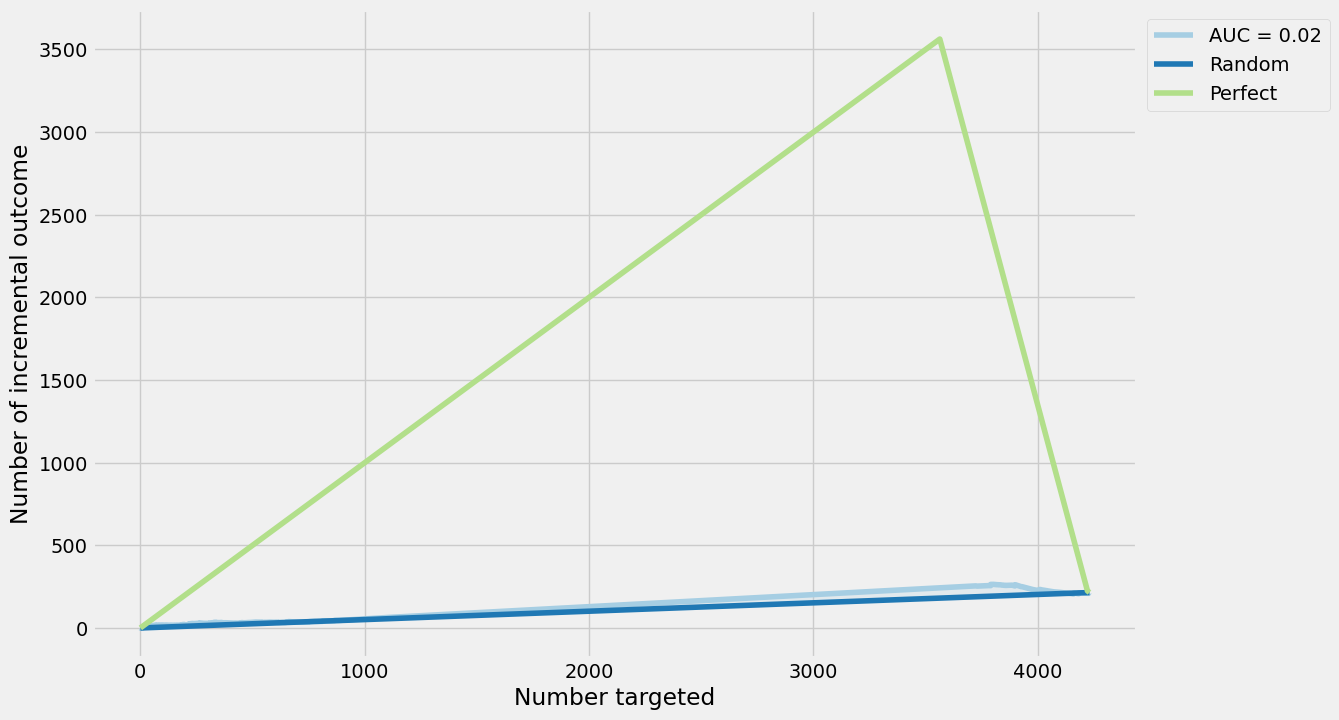

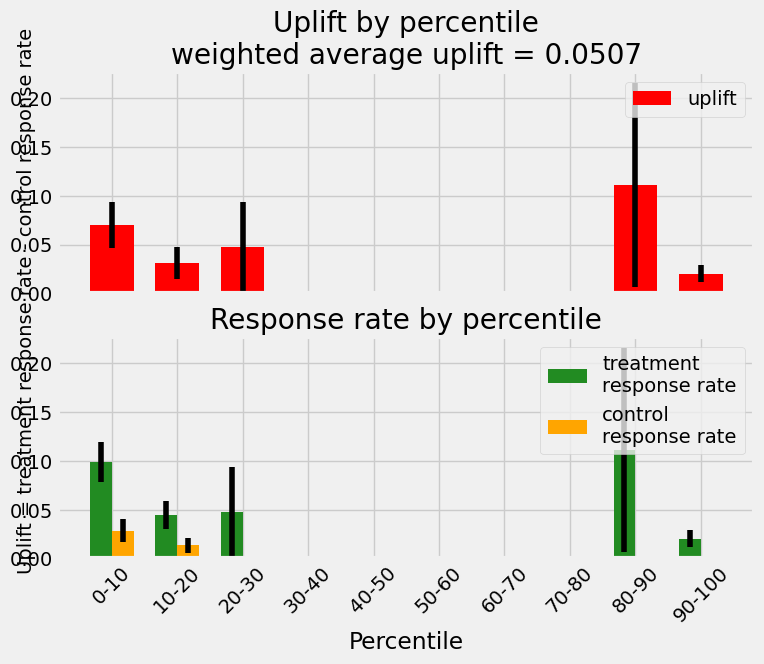

In [10]:
data1 = {'y_to_pred':y_test, 'uplift': dragon_predict[:,0] , 'treatment':treatment_test}


#data.sort_values( by=['uplift'] )
plot_qini_curve(y_true=data1['y_to_pred'], uplift=data1['uplift'], treatment=data1['treatment'])
plot_uplift_curve(y_true=data1['y_to_pred'], uplift=data1['uplift'], treatment=data1['treatment'])
plot_uplift_by_percentile(y_true=data1['y_to_pred'], uplift=data1['uplift'], treatment=data1['treatment'],kind='bar')